# Week 6 : Artificial neural network in PyTorch
```
- Machine Learning, Innopolis University (Fall semester 2024)
- Instructors: Adil Khan & Gcinizwe Dlamini
```
<hr>

In this lab, you will practice simple deep learning model in Pytorch.
```
Lab Plan
1. Theoretical issues with ANNs
2. Deep learning frameworks
3. Introduction to Pytorch : Linear Regression with Pytorch
3. Simple ANN model for classification
4. Training ANNs
```

<hr>


## 1. Theoretical issues
Ordinary fully connected neural nets consists of Dense layers, activations, and output layer.

1. What's the difference between deep learning and normal machine learning?
2. How does a neural network with no hidden layers and one output neuron compare to a logistic/linear regression?
3. Can the perceptron find a non-linear decision boundary?
4. In multi-hidden layers network, what's the need of non-linear activation function?
5. Is random weight assignment better than assigning same weights to the units in the hidden layer.
---

## 2. Deep learning framework : PyTorch

Getting started with Pytorch

## 2.1 Linear Regression with Numpy

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sqlalchemy import create_engine, text

In [5]:
QUERY = """
select
    order_history.order_id,
    order_history.STATUS_ID,
    start_prepare.VALUE start_prepare_time,
    order_ready.VALUE order_ready_time,
    sale_basket.store_id,
    sale_basket.product_id
from order_history
inner join main.order_props_value order_ready on order_history.order_id = order_ready.order_id and order_ready.ORDER_PROPS_ID = 95
inner join main.order_props_value start_prepare on order_history.order_id = start_prepare.order_id and start_prepare.ORDER_PROPS_ID = 97
inner join order_busket AS sale_basket ON sale_basket.order_id = order_history.order_id
where sale_basket.store_id = 5863
"""


session_engine = create_engine('sqlite:///mlAssignmentOne.db')

with session_engine.connect() as conn:
    assignment_data = pd.read_sql_query(sql=text(QUERY), con=conn)

for column in ['order_ready_time','start_prepare_time']:
  assignment_data[column] = pd.to_datetime(assignment_data[column], errors="coerce")


assignment_data.dropna(axis=0, inplace=True)
assignment_data.sort_values(by='start_prepare_time', inplace=True)
assignment_data["prep_time"] = (assignment_data.order_ready_time - assignment_data.start_prepare_time).dt.seconds // 60

In [6]:
def generate_data(size=100, train_ratio=0.8, data_type='random'):
  indices = np.arange(size)
  if data_type == 'random':
    # Generate random x values and corresponding y values with added noise
    x = np.random.rand(size, 1)
    y = 3 + 2.5 * x + 0.1 * np.random.randn(size, 1)

    # Shuffle the indices to randomize the data
    np.random.shuffle(indices)

  else:
    tot_items = assignment_data.groupby("order_id").apply(lambda x: len(x)).reset_index().rename(columns={0: 'tot_items'})
    prep_time = assignment_data.drop_duplicates(subset=['order_id'])[['order_id', 'prep_time']]
    data = pd.merge(left=tot_items, right=prep_time, on='order_id').drop('order_id', axis=1).reset_index(drop=True)
    x = data['tot_items'].values[:size]
    y = data['prep_time'].values[:size]
  # Split the indices based on the train-validation ratio
  split_idx = int(size * train_ratio)
  train_indices = indices[:split_idx]
  val_indices = indices[split_idx:]

  # Generate train and validation datasets
  x_train, y_train = x[train_indices], y[train_indices]
  x_val, y_val = x[val_indices], y[val_indices]

  return x_train, y_train, x_val, y_val

## Generate Dataset

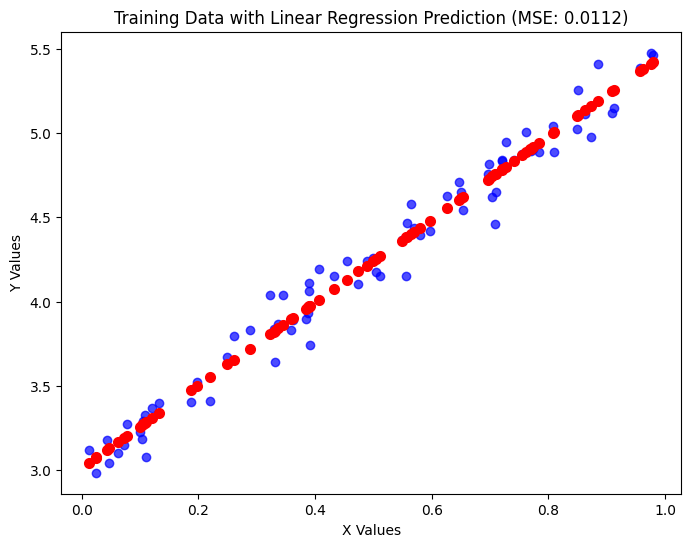

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate data
x_train, y_train, x_val, y_val = generate_data(data_type='random')

# Reshape x_train for sklearn
x_train_reshaped = x_train.reshape(-1, 1)

# Fit the linear regression model
model = LinearRegression()
model.fit(x_train_reshaped, y_train)

# Make predictions
y_pred = model.predict(x_train_reshaped)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_train, y_pred)

# Create a DataFrame for easier plotting
data = {
    'X Values': x_train.flatten(),  # Flatten in case it's a 2D array
    'Y Values': y_train.flatten(),   # Flatten in case it's a 2D array
    'Predicted Values': y_pred.flatten()
}

# Create the scatter plot for training data
plt.figure(figsize=(8, 6))
plt.scatter(data['X Values'], data['Y Values'], color='blue', alpha=0.7)
plt.title(f'Training Data with Linear Regression Prediction (MSE: {mse:.4f})')
plt.xlabel('X Values')
plt.ylabel('Y Values')

# Add model predictions as a line
plt.scatter(data['X Values'], data['Predicted Values'], color='red', linewidth=2, label='Linear Regression Prediction')

# Show the plot
plt.show()


## Gradient Descent algorithm

Gradient descent consist of 3 basic steps :

1. **Compute the Loss**

$$ \hat{y} = a + bx + \epsilon $$

$$ \text{MSE} = \frac{1}{N} \sum_{i} (y_i - \hat{y}_i)^2 $$

$$ \text{MSE} = \frac{1}{N} \sum_{i} (y_i - a - bx_i)^2 $$

2. **Compute the Gradients** : A gradient is a partial derivative. Using the chain rule the final expression came to be :

$$\frac{\partial \text{MSE}}{\partial a} = \frac{\partial \text{MSE}}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial a} = -2 * \frac{1}{N} \sum_{i} (y_i - \hat{y}_i)$$

$$\frac{\partial \text{MSE}}{\partial b} = \frac{\partial \text{MSE}}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial b} = -2 * \frac{1}{N} \sum_{i} x_i(y_i - \hat{y}_i)$$

3. **Update the Parameters**

$$a = a - \alpha \frac{\partial \text{MSE}}{\partial a}$$

$$b = b - \alpha \frac{\partial \text{MSE}}{\partial b}$$

4. Repeat step 1 to 3 till convergence is reached

## Linear Regression model training

In [8]:
# Initialize parameters "a" and "b" randomly
a = np.random.randn(1)
b = np.random.randn(1)

print(f"Initial values of [a, b]: [{a[0]:.4f}, {b[0]:.4f}]")

learning_rate = 1e-1  # Learning rate
n_epochs = 100  # Number of iterations

for epoch in range(n_epochs):
    # Step 1: Compute predicted values (y_hat)
    y_hat = a * x_train + b

    # Step 2: Compute error and Mean Squared Error (MSE) Loss
    error = y_hat - y_train
    loss = (1 / len(x_train)) * np.sum(error**2)

    # Step 3: Compute gradients for parameters "a" and "b"
    a_grad = (2 / len(x_train)) * np.sum(error)
    b_grad = (2 / len(x_train)) * np.sum(x_train * error)

    # Step 4: Update parameters using the gradients and learning rate
    a -= learning_rate * a_grad
    b -= learning_rate * b_grad

    # Optional: Print loss every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6f}")

# Final values of parameters after training
print(f"Final values of [a, b]: [{a[0]:.4f}, {b[0]:.4f}]")

Initial values of [a, b]: [0.8239, 0.4156]
Epoch 0: Loss = 11.872061
Epoch 10: Loss = 0.347107
Epoch 20: Loss = 0.338465
Epoch 30: Loss = 0.451185
Epoch 40: Loss = 0.604068
Epoch 50: Loss = 0.810079
Epoch 60: Loss = 1.087674
Epoch 70: Loss = 1.461722
Epoch 80: Loss = 1.965739
Epoch 90: Loss = 2.644886
Final values of [a, b]: [8.8783, -0.6691]


## Pytorch basics

### Tensors

* How to create a Tensor
* Operations on tensors
* Data types for Tensors### Create a Tensor

Create tensors from Numpy then see what operations can be applied.
**Note:** By default a tensor resides in cpu but can be sent to the GPU for fatser computations

In [9]:
import torch

# Check device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy arrays to tensors and move to the selected device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Print type and device information
print(f"Original type: {type(x_train)}")
print(f"Tensor type: {x_train_tensor.type()}, Device: {x_train_tensor.device}")

Original type: <class 'numpy.ndarray'>
Tensor type: torch.cuda.FloatTensor, Device: cuda:0


## Linear Regression (Numpy -> PyTorch)

In [10]:
import torch

# Initialize parameters "a" and "b" on the correct device
a = torch.randn(1, device=device, requires_grad=False)
b = torch.randn(1, device=device, requires_grad=False)

# Convert numpy arrays to tensors and move to the selected device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

learning_rate = 1e-1  # Learning rate
n_epochs = 100  # Number of iterations

for epoch in range(n_epochs):
    # Step 1: Compute predicted values (yhat)
    yhat = a + b * x_train_tensor

    # Step 2: Compute error and MSE loss
    error = y_train_tensor - yhat
    loss = torch.mean(error**2)

    # Step 3: Compute gradients (partial derivatives for "a" and "b")
    a_grad = -(2 / len(x_train_tensor)) * torch.sum(error)
    b_grad = -(2 / len(x_train_tensor)) * torch.sum(x_train_tensor * error)

    # Step 4: Update parameters using gradients and learning rate
    a -= learning_rate * a_grad
    b -= learning_rate * b_grad

    # Optional: Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Print final values of "a" and "b"
print(f"Final values of [a, b]: [{a.item():.4f}, {b.item():.4f}]")

Epoch 0: Loss = 1.433089
Epoch 10: Loss = 0.020834
Epoch 20: Loss = 0.015464
Epoch 30: Loss = 0.014484
Epoch 40: Loss = 0.013734
Epoch 50: Loss = 0.013154
Epoch 60: Loss = 0.012706
Epoch 70: Loss = 0.012358
Epoch 80: Loss = 0.012089
Epoch 90: Loss = 0.011881
Final values of [a, b]: [3.0557, 2.3788]


### 2.1 Feed Forward Neural Network
An artificial neural network wherein connections between the nodes do not form a cycle.
<!--![alt text](https://upload.wikimedia.org/wikipedia/en/5/54/Feed_forward_neural_net.gif)
![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/2294px-Artificial_neural_network.svg.png)-->

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Artificial_neural_network.svg/2294px-Artificial_neural_network.svg.png" width="1000"/>
</div>


### Model Design in Pytorch
we have three simple parts that we need to build:
1. Data Loading process.
2. Model building.
3. the training loops.

<strong>Data Loading</strong>

Data Loading in pytorch is very easy and broken into 3 steps:
1. Data Source
2. Data Transformations
3. Data Loader



## 3. Loading data

Pytorch uses data loading utility which is called `DataLoader` that supports:
automatic batching, transformation, single- and multi-process data loading and more..

In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set batch sizes
batch_size = 32
test_batch_size = 100

# Define data transformations: convert to tensor and normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST dataset
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)

# Create DataLoader for training and testing datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Print to verify data loading
print(f"Training data: {len(train_loader.dataset)} samples")
print(f"Test data: {len(test_loader.dataset)} samples")

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 9912422/9912422 [00:03<00:00, 3253034.09it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 28881/28881 [00:00<00:00, 220793.08it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1250447.07it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>



100%|██████████| 4542/4542 [00:00<00:00, 3534420.92it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Training data: 60000 samples
Test data: 10000 samples


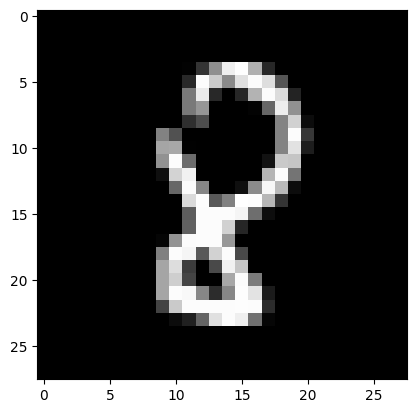

In [12]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.imshow(images[0].reshape(28,28), cmap="gray")

## 4. Model building
1. Defining components: <br/>
This step is done in the constructor, where you will define the layers that will be used accordingly in the next step.
2. Network flow: <br/>
This step is done in the forward function. Where you will get the input batch as an argument then you will use the defined layers in the previous step to define the flow of the network then you will return the output batch.


Pytorch is a dynamic framework, where you can use primitive python keywords with it.
You can use if and while statements. Also, it can accepts and returns more than one batch.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)  # First hidden layer
        self.fc2 = nn.Linear(500, 250)       # Second hidden layer
        self.fc3 = nn.Linear(250, 100)       # Third hidden layer
        self.fc4 = nn.Linear(100, 10)        # Output layer (10 classes)
        self.dropout = nn.Dropout(0.5)       # Dropout layer for regularization

    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 28 * 28)
        # Pass through the first layer and apply ReLU activation
        x = F.relu(self.fc1(x))
        # Apply dropout
        x = self.dropout(x)
        # Pass through the second layer and apply ReLU activation
        x = F.relu(self.fc2(x))
        # Apply dropout
        x = self.dropout(x)
        # Pass through the third layer and apply ReLU activation
        x = F.relu(self.fc3(x))
        # Pass through the output layer with log softmax
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

# Check for CUDA availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

## 5. Training loops
After that we should define the loops over tha batches and run the training on.

In [14]:
# Define training params
epochs = 5
lr = 0.01
momentum = 0.5

## 5.1 Define the training procedure

In [15]:
import torch

def train(model, device, train_loader, optimizer, epoch, criterion=torch.nn.functional.nll_loss):
    model.train()  # Set model to training mode
    total_loss = 0  # To track total loss for the epoch

    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and targets to the specified device (CPU/GPU)
        data, target = data.to(device), target.to(device)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Compute model predictions
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backward pass: Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss for the entire epoch
        total_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f'====> Epoch: {epoch} Average Training loss: {avg_loss:.6f}')


## 5.2 Define the evaluation procedure

In [16]:
def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for data, target in test_loader:
            # Move the data and target tensors to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)

            # Get the model's output predictions
            output = model(data)

            # Compute the loss using negative log likelihood
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss

            # Get the index of the max log-probability for predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss across the entire test dataset
    test_loss /= len(test_loader.dataset)

    # Print the average loss and accuracy
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## 5.3 Training Model

In [17]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

====> Epoch: 1 Average Training loss: 0.696030
Test set: Average loss: 0.2140, Accuracy: 9349/10000 (93%)

====> Epoch: 2 Average Training loss: 0.251658
Test set: Average loss: 0.1410, Accuracy: 9563/10000 (96%)

====> Epoch: 3 Average Training loss: 0.184325
Test set: Average loss: 0.1099, Accuracy: 9667/10000 (97%)

====> Epoch: 4 Average Training loss: 0.151952
Test set: Average loss: 0.0926, Accuracy: 9707/10000 (97%)

====> Epoch: 5 Average Training loss: 0.128898
Test set: Average loss: 0.0837, Accuracy: 9741/10000 (97%)



## 6. Save model

In [18]:
model_save_path = 'model.pth'  # Specify the filename for saving the model
torch.save(model.state_dict(), model_save_path)  # Save the model's state dict
print(f'Model saved to {model_save_path}')

Model saved to model.pth


## <center>Self-practice <center>

Using Dataset from assignment 1
1. Define, train and evaluate an ANN for Regression and Classification
1. Plot the loss and accuracy of the model for each training iteration
    
ANN should be implemented in PyTorch

In [7]:
import pandas as pd
import os

assignment_data_path = os.path.join(os.getcwd(), 'assignment_data')

X_train = pd.read_csv(os.path.join(assignment_data_path, 'regression', 'train_simple.csv'))
X_test = pd.read_csv(os.path.join(assignment_data_path, 'regression', 'test_simple.csv'))

y_train = pd.read_csv(os.path.join(assignment_data_path,'regression', 'y_train_simple.csv')).squeeze()
y_test = pd.read_csv(os.path.join(assignment_data_path, 'regression', 'y_test_simple.csv')).squeeze()

In [8]:
import matplotlib.pyplot as plt
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [10]:
import importlib
import ann
importlib.reload(ann)
net, train_metrics, test_metrics = ann.train_ann(X_train=X_train, 
												y_train=y_train, 
												X_test=X_test, 
												y_test=y_test,
												ann_hidden_units=[512, 256, 32], 
												num_epochs=5,
												task='regression',
												version_number="simple")

c:\Users\bouab\DEV\Towards_Data_Science\Machine_Learning\__uni\ann.py:45: UserWarning: the env variable 'CUBLAS_WORKSPACE_CONFIG' is set to the value :4096:8. setting it to: ':16:8' 
  warnings.warn(message=f"the env variable 'CUBLAS_WORKSPACE_CONFIG' is set to the value {env_var}. setting it to: ':16:8' ")
epoch: 1 iterating through train dataset: 100%|██████████| 998/998 [00:09<00:00, 101.84it/s]


epoch: 1: train loss: 60.2513759590103


 20%|██        | 1/5 [00:10<00:41, 10.45s/it]

epoch: 1: val loss: 98.43791843282766


epoch: 2 iterating through train dataset: 100%|██████████| 998/998 [00:07<00:00, 134.37it/s]


epoch: 2: train loss: 58.629843262727846


 40%|████      | 2/5 [00:18<00:27,  9.09s/it]

epoch: 2: val loss: 97.03481838620942


epoch: 3 iterating through train dataset: 100%|██████████| 998/998 [00:07<00:00, 134.24it/s]


epoch: 3: train loss: 58.17045712901022


 60%|██████    | 3/5 [00:26<00:17,  8.59s/it]

epoch: 3: val loss: 97.24453998434133


epoch: 4 iterating through train dataset: 100%|██████████| 998/998 [00:07<00:00, 137.44it/s]


epoch: 4: train loss: 57.9297310632312


 80%|████████  | 4/5 [00:34<00:08,  8.32s/it]

epoch: 4: val loss: 98.35005260335988


epoch: 5 iterating through train dataset: 100%|██████████| 998/998 [00:07<00:00, 134.02it/s]


epoch: 5: train loss: 57.72935253441453


100%|██████████| 5/5 [00:42<00:00,  8.53s/it]


epoch: 5: val loss: 96.8093612933981


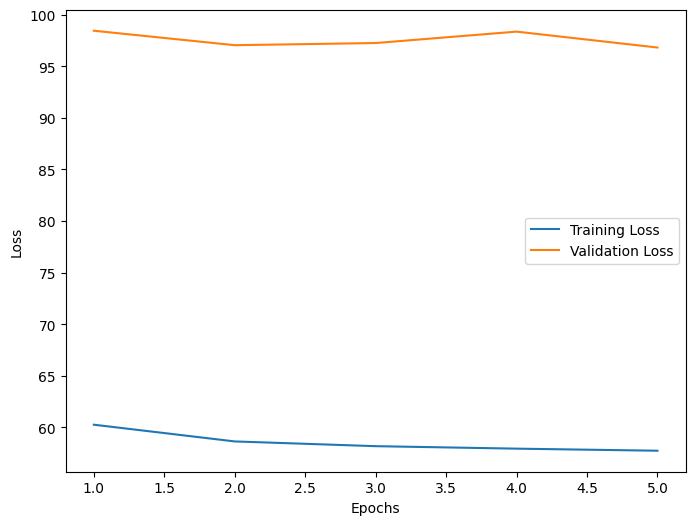

In [14]:
train_losses = [k for v, k in train_metrics.items() if v.startswith('train_loss')]
val_losses = [k for v, k in train_metrics.items() if v.startswith('val_loss')]
plot_loss(train_losses, val_losses)

In [15]:
X_train = pd.read_csv(os.path.join(assignment_data_path, 'classification', 'train_simple.csv'))
X_test = pd.read_csv(os.path.join(assignment_data_path, 'classification', 'test_simple.csv'))

y_train = pd.read_csv(os.path.join(assignment_data_path,'classification', 'y_train_simple.csv')).squeeze()
y_test = pd.read_csv(os.path.join(assignment_data_path, 'classification', 'y_test_simple.csv')).squeeze()

In [28]:
importlib.reload(ann)
net, train_metrics, test_metrics = ann.train_ann(X_train=X_train, 
												y_train=y_train, 
												X_test=X_test, 
												y_test=y_test,
												ann_hidden_units=[512, 256, 32], 
												num_epochs=5,
												task='classification',
												version_number="simple")

epoch: 1 iterating through train dataset: 100%|██████████| 998/998 [00:08<00:00, 121.20it/s]


epoch: 1: train loss: 0.6890174747707849


 20%|██        | 1/5 [00:08<00:35,  8.84s/it]

epoch: 1: val loss: 0.6765226774048387


epoch: 2 iterating through train dataset: 100%|██████████| 998/998 [00:08<00:00, 113.85it/s]


epoch: 2: train loss: 0.6749512480351634


 40%|████      | 2/5 [00:18<00:27,  9.22s/it]

epoch: 2: val loss: 0.6712211433209871


epoch: 3 iterating through train dataset: 100%|██████████| 998/998 [00:08<00:00, 112.86it/s]


epoch: 3: train loss: 0.6731737426861015


 60%|██████    | 3/5 [00:27<00:18,  9.33s/it]

epoch: 3: val loss: 0.673270701316365


epoch: 4 iterating through train dataset: 100%|██████████| 998/998 [00:08<00:00, 113.16it/s]


epoch: 4: train loss: 0.6719854746409551


 80%|████████  | 4/5 [00:37<00:09,  9.38s/it]

epoch: 4: val loss: 0.67270652139396


epoch: 5 iterating through train dataset: 100%|██████████| 998/998 [00:08<00:00, 112.18it/s]


epoch: 5: train loss: 0.6710223475534596


100%|██████████| 5/5 [00:46<00:00,  9.36s/it]


epoch: 5: val loss: 0.6739856213854071


In [29]:
train_metrics

{'train_loss_epoch_1': 0.6890174747707849,
 'train_accuracy_1': 0.561885489729459,
 'val_loss_epoch_ 1': 0.6765226774048387,
 'val_accuracy_1': 0.1944720326808461,
 'train_loss_epoch_2': 0.6749512480351634,
 'train_accuracy_2': 0.5760427104208417,
 'val_loss_epoch_ 2': 0.6712211433209871,
 'val_accuracy_2': 0.21185038382546945,
 'train_loss_epoch_3': 0.6731737426861015,
 'train_accuracy_3': 0.5787903932865731,
 'val_loss_epoch_ 3': 0.673270701316365,
 'val_accuracy_3': 0.2147467721972549,
 'train_loss_epoch_4': 0.6719854746409551,
 'train_accuracy_4': 0.5805615136523046,
 'val_loss_epoch_ 4': 0.67270652139396,
 'val_accuracy_4': 0.20523006455940113,
 'train_loss_epoch_5': 0.6710223475534596,
 'train_accuracy_5': 0.5814519664328658,
 'val_loss_epoch_ 5': 0.6739856213854071,
 'val_accuracy_5': 0.20729891040868925,
 'rmse': 0.8635,
 'mae': 0.6933,
 'r2': -1.9852}

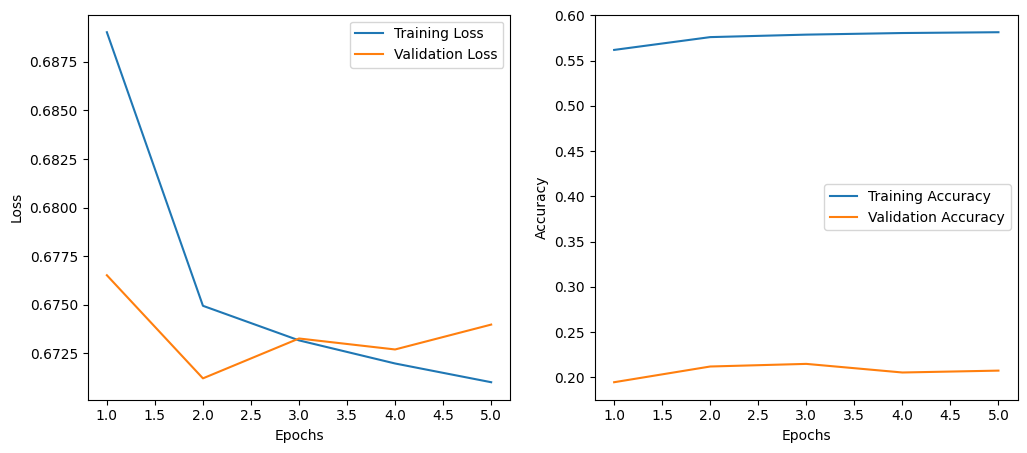

In [30]:
train_losses = [k for v, k in train_metrics.items() if v.startswith('train_loss')]
val_losses = [k for v, k in train_metrics.items() if v.startswith('val_loss')]

train_accs = [k for v, k in train_metrics.items() if v.startswith('train_acc')]
val_accs = [k for v, k in train_metrics.items() if v.startswith('val_acc')]

plot_metrics(train_losses, val_losses, train_accs, val_accs)